# Simulate affect of TVL increase on APY in sensei strategies


Sensei strategies deposit and borrow from zklend and nostra. Use the current supply and borrow TVL of these protocols along with APY formula of them to understand the affects of deposits into sensei strategy on net apy

Output:
For each of the strategies, plot deposit (usd) vs apy plot. Meaning how does apy change as u increase deposit. The deposit range is from 10k usd to 10M.

Also plot the individual deposit and borrow ApYs of the pools involved for each of the protocols against deposit usd.


Notes: 
1. To obtain the values of pool parameters for calculating interest rates, in case of Zklend follow this page () and get the equations and then use these pages (https://app.zklend.com/asset/ETH) to back calculate slopes and intercepts.
2. In case of nostra the same equations hold. But the details of the paramters are present in the contract https://starkscan.co/contract/0x059a943ca214c10234b9a3b61c558ac20c005127d183b86a99a8f3c60a08b4ff#read-write-contract.
3. Here, give the Nostra: ETH debt token and Nostra: USDC debt token as inputs to get corresponding parameters. The token addresses can be obtained in 2 ways 
4. One is by directly searching on starkscan 
5. Other way is by going to deth in the bottomost dropdown in this page https://app.nostra.finance/lend-borrow/ETH/deposit
Nostra USDC debt token: 0x063d69ae657bd2f40337c39bf35a870ac27ddf91e6623c2f52529db4c1619a51
Nostra ETH debt token: 0x00ba3037d968790ac486f70acaa9a1cab10cf5843bb85c986624b4d0e5a82e74
Nostra strk debt token: 0x001258eae3eae5002125bebf062d611a772e8aea3a1879b64a19f363ebd00947
6. From strkfarm open source code, obtained the multiplers to obtain total supply and borrow from each pool for each token
7. The value of borrow cap for zklend is available at https://app.zklend.com/asset/USDC
8. The value of borrow cap for nostra is available at the debt token contract, the max supply cap for the debt tokens acts as a proxy for borrow limit. 
Go to the dropdown at the bottom here and click on the dtoken: https://app.nostra.finance/lend-borrow/USDC/deposit
token contract: https://starkscan.co/contract/0x063d69ae657bd2f40337c39bf35a870ac27ddf91e6623c2f52529db4c1619a51#read-write-contract


Assumptions:
1. stark rewards will roughly be the same till at least for 10 million TVL investment in this strategy. 
2. The base supply and borrow values are set according to today's value (13th Sept 2024)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Defining borrow and deposit apy functions

In [2]:
def apy_borrow(U, Uoptimal, R0, S1, S2):
    if U <= Uoptimal:
        return R0 + S1 * U / Uoptimal
    else:
        return R0 + S1 + S2 * (U - Uoptimal) / (100 - Uoptimal)

def apy_deposit(borrow_apy, U, protocol_fee, reward_deposit_apy):
    return borrow_apy * U / 100 * (1 - protocol_fee) + reward_deposit_apy

# Data collection

In [3]:
# protocol data and deposits
deposits = np.linspace(10_000, 10_000_000, 100)  # Example deposit range
protocols = {
    "zklend": {
        "eth": {
            "total_supply": 13.14 * 1e6,
            "total_borrow": 3.60 * 1e6,
            "R0": 0,
            "S1": 5.13,
            "S2": 180.64,
            "Uoptimal": 65,
            "protocol_fee": 0.10,
            "reward_deposit_apy": 8.5,
            "borrow_limit": 5.89 * 1e6

        },
        "usdc": {
            "total_supply": 7.10 * 1e6,
            "total_borrow": 3.96 * 1e6,
            "R0": 0,
            "S1": 6.18,
            "S2": 142.25,
            "Uoptimal": 70,
            "protocol_fee": 0.10,
            "reward_deposit_apy": 9.5,
            "borrow_limit": 20 * 1e6
        },
        "strk": {
            "total_supply": 8.99 * 1e6,
            "total_borrow": 1.6 * 1e6,
            "R0": 0,
            "S1": 10.52,
            "S2": 248.22,
            "Uoptimal": 60,
            "protocol_fee": 0.16,
            "reward_deposit_apy": 9.11,
            "borrow_limit": 2.47 * 1e6

        }
    },
    "nostra": {
        "eth": {
            "total_supply": 79.03 * 1e6,
            "total_borrow": 10.03 * 1e6,
            "R0": 0,
            "S1": 6.83,
            "S2": 100,
            "Uoptimal": 70,
            "protocol_fee": 0.5,
            "reward_deposit_apy": 8.5,
            "borrow_limit": 50 * 1e6

        },
        "usdc": {
            "total_supply": 19.3 * 1e6,
            "total_borrow": 6.8 * 1e6,
            "R0": 0,
            "S1": 11.11,
            "S2": 100,
            "Uoptimal": 70,
            "protocol_fee": 0.2,
            "reward_deposit_apy": 9.5,
            "borrow_limit": 40 * 1e6
        },
        "strk": {
            "total_supply": 33.5 * 1e6,
            "total_borrow": 10.74 * 1e6,
            "R0": 0,
            "S1": 7,
            "S2": 100,
            "Uoptimal": 70,
            "protocol_fee": 0.3,
            "reward_deposit_apy": 9.03,
            "borrow_limit": 40 * 1e6

        }
      }
    }


# Function to plot the APY outputs

In [66]:
# Function to plot the APY and Net APY results
def plot_apy_and_net_apy(deposits, apy1_list, apy2_list, apy3_list, apy4_list, net_apy_list, token0, token1, step2_multiplier):
    # Plot net APY
    plt.figure(figsize=(12, 8))
    valid_indices = np.where(np.array(net_apy_list) >= -25)[0]
    
    if len(valid_indices) > 0:
        max_valid_index = valid_indices[-1] + 1  # Get the index up to which we should plot
    else:
        max_valid_index = len(deposits)  # If no net APY >= -25, plot all

    # Limit the lists up to max_valid_index
    limited_deposits = deposits[:max_valid_index]
    limited_net_apy = net_apy_list[:max_valid_index]
    limited_apy1 = apy1_list[:max_valid_index]
    limited_apy2 = apy2_list[:max_valid_index]
    limited_apy3 = apy3_list[:max_valid_index]
    limited_apy4 = apy4_list[:max_valid_index]
    
    plt.plot(limited_deposits / 1e6, limited_net_apy, label="Net APY", linestyle='-', color='red')
    
    borrow_limit_zklend = (protocols['zklend'][token1.lower()]['borrow_limit'] - protocols['zklend'][token1.lower()]['total_borrow']) / 1e6/step2_multiplier
    borrow_limit_nostra = (protocols['nostra'][token0.lower()]['borrow_limit'] - protocols['nostra'][token0.lower()]['total_borrow']) / 1e6/step2_multiplier
    # Detect the tipping point (sudden change in slope)
    slopes = np.diff(limited_net_apy) / np.diff(limited_deposits)
    slope_threshold = -0.5  # Adjust threshold for slope drop detection
    tipping_point_index = np.argmax(slopes < slope_threshold) + 1  # +1 to account for diff reducing size by 1
    tipping_point_deposit = limited_deposits[tipping_point_index] if tipping_point_index < len(limited_deposits) else max(limited_deposits)
    # Optimal deposit is the minimum of the tipping point and the borrow limits
    optimal_deposit = min(tipping_point_deposit, borrow_limit_zklend, borrow_limit_nostra)
    
    # Adding vertical lines for deposit limits
    if borrow_limit_zklend < max(limited_deposits) / 1e6:
        plt.axvline(x=borrow_limit_zklend, color='purple', linestyle='--', label=f"Deposit Limit ({borrow_limit_zklend:.2f}M)")
#         plt.text(borrow_limit_zklend, plt.ylim()[1] * 0.9, f"{borrow_limit_zklend:.2f}M", color='purple', rotation=90)

    if borrow_limit_nostra < max(limited_deposits) / 1e6:
        plt.axvline(x=borrow_limit_nostra, color='orange', linestyle='--', label=f"Deposit Limit ({borrow_limit_nostra:.2f}M)")
#         plt.text(borrow_limit_nostra, plt.ylim()[1] * 0.9, f"{borrow_limit_nostra :.2f}M", color='orange', rotation=90)

    # Plot vertical line for the optimal deposit
    if optimal_deposit < max(limited_deposits) / 1e6:
        plt.axvline(x=optimal_deposit, color='pink', linestyle='-', label=f"Optimal Deposit ({optimal_deposit:.2f}M)")
#         plt.text(optimal_deposit, plt.ylim()[1] * 0.8, f"Optimal {optimal_deposit:.2f}M", color='pink', rotation=90)

    if token0 == "ETH" and token1 == "USDC":
        plt.axvline(x=1.02, color='pink', linestyle='-', label=f"Optimal Deposit ({1.02:.2f}M)")
    
    # Labels and legends
    plt.xlabel("Deposit (million USD)")
    plt.ylabel("APY (%)")
    plt.title(f"Net APY vs Deposit (million USD) for {token0} and {token1}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot APY1, APY2, APY3, APY4
    plt.figure(figsize=(12, 8))
    plt.plot(limited_deposits / 1e6, limited_apy1, label=f"APY1 (ZkLend {token0} Deposit)", linestyle='-', color='blue')
    plt.plot(limited_deposits / 1e6, limited_apy2, label=f"APY2 (ZkLend {token1} Borrow)", linestyle='--', color='blue')
    plt.plot(limited_deposits / 1e6, limited_apy3, label=f"APY3 (Nostra {token1} Deposit)", linestyle='-', color='green')
    plt.plot(limited_deposits / 1e6, limited_apy4, label=f"APY4 (Nostra {token0} Borrow)", linestyle='--', color='green')


    # Adding vertical lines for borrow limits
    if borrow_limit_zklend < max(limited_deposits) / 1e6:
        plt.axvline(x=borrow_limit_zklend, color='purple', linestyle='--', label=f"Deposit Limit ({borrow_limit_zklend:.2f}M)")
#         plt.text(borrow_limit_zklend, plt.ylim()[1] * 0.9, f"{borrow_limit_zklend:.2f}M", color='purple', rotation=90)

    if borrow_limit_nostra < max(limited_deposits) / 1e6:
        plt.axvline(x=borrow_limit_nostra, color='orange', linestyle='--', label=f"Deposit Limit ({borrow_limit_nostra:.2f}M)")
#         plt.text(borrow_limit_nostra, plt.ylim()[1] * 0.9, f"{borrow_limit_nostra :.2f}M", color='orange', rotation=90)
    # Plot vertical line for the optimal deposit
    if optimal_deposit < max(limited_deposits) / 1e6:
        plt.axvline(x=optimal_deposit, color='pink', linestyle='-', label=f"Optimal Deposit ({optimal_deposit:.2f}M)")
#         plt.text(optimal_deposit, plt.ylim()[1] * 0.8, f"Optimal {optimal_deposit:.2f}M", color='pink', rotation=90)

    if token0 == "ETH" and token1 == "USDC":
        plt.axvline(x=1.02, color='pink', linestyle='-', label=f"Optimal Deposit ({1.02:.2f}M)")
        
    # Labels and legends
    plt.xlabel("Deposit (million USD)")
    plt.ylabel("APY (%)")
    plt.title(f"APYs vs Deposit (million USD) for {token0} and {token1}")
    plt.legend()
    plt.grid(True)
    plt.show()


# APY calculation

In [67]:
# Function to calculate APYs for input tokens from both ZkLend and Nostra protocols
def calculate_apy_for_tokens(token0_input, token1_input, protocols, deposits):
    valid_tokens = ['ETH', 'USDC', 'STRK']
    
    if token0_input not in valid_tokens or token1_input not in valid_tokens:
        raise ValueError(f"Invalid tokens. Tokens must be one of {valid_tokens}")
    
    # Dynamically assign token data for ZkLend and Nostra
    token0_data_zklend = protocols['zklend'].get(token0_input.lower())
    token1_data_zklend = protocols['zklend'].get(token1_input.lower())
    
    token0_data_nostra = protocols['nostra'].get(token0_input.lower())
    token1_data_nostra = protocols['nostra'].get(token1_input.lower())
    
    if not token0_data_zklend or not token1_data_zklend or not token0_data_nostra or not token1_data_nostra:
        raise ValueError(f"Protocol data not found for one or both tokens: {token0_input}, {token1_input}")
    

    if token0_input == "USDC" and token1_input == "ETH":
        step1_multiplier = 1.552509
        step2_multiplier = 0.945081
        step4_multiplier = 0.552509
    elif token0_input == "ETH" and token1_input == "USDC":
        step1_multiplier = 1.510078
        step2_multiplier = 0.920975
        step4_multiplier = 0.510078   
    elif token0_input == "STRK" and token1_input == "ETH":
        step1_multiplier = 1.233276
        step2_multiplier = 0.473843
        step4_multiplier = 0.233276 
    # Arrays to store the APY results
    apy1_list, apy2_list, apy3_list, apy4_list, net_apy_list = [], [], [], [], []
    
    # Calculate APY for each deposit amount in each protocol
    for deposit in deposits:
        # ZkLend calculations
        effective_deposit_zkLend_step1 = deposit * step1_multiplier
        effective_borrow_zkLend_step2 = deposit * step2_multiplier

        total_supply_token0_zk = token0_data_zklend['total_supply'] + effective_deposit_zkLend_step1
        U_token0_zk = token0_data_zklend['total_borrow'] / total_supply_token0_zk * 100
        apy1 = apy_deposit(apy_borrow(U_token0_zk, token0_data_zklend['Uoptimal'], token0_data_zklend['R0'], token0_data_zklend['S1'], token0_data_zklend['S2']),
                           U_token0_zk, token0_data_zklend['protocol_fee'], token0_data_zklend['reward_deposit_apy'])
        apy1_list.append(apy1)

        total_borrow_token1_zk = token1_data_zklend['total_borrow'] + effective_borrow_zkLend_step2
        U_token1_zk = total_borrow_token1_zk / token1_data_zklend['total_supply'] * 100
        apy2 = apy_borrow(U_token1_zk, token1_data_zklend['Uoptimal'], token1_data_zklend['R0'], token1_data_zklend['S1'], token1_data_zklend['S2'])
        apy2_list.append(apy2)

        # Nostra calculations
        effective_deposit_nostra_step3 = deposit * step2_multiplier
        effective_borrow_nostra_step4 = deposit * step4_multiplier

        total_supply_token1_nostra = token1_data_nostra['total_supply'] + effective_deposit_nostra_step3
        U_token1_nostra = token1_data_nostra['total_borrow'] / total_supply_token1_nostra * 100
        apy3 = apy_deposit(apy_borrow(U_token1_nostra, token1_data_nostra['Uoptimal'], token1_data_nostra['R0'], token1_data_nostra['S1'], token1_data_nostra['S2']),
                           U_token1_nostra, token1_data_nostra['protocol_fee'], token1_data_nostra['reward_deposit_apy'])
        apy3_list.append(apy3)

        total_borrow_token0_nostra = token0_data_nostra['total_borrow'] + effective_borrow_nostra_step4
        U_token0_nostra = total_borrow_token0_nostra / token0_data_nostra['total_supply'] * 100
        apy4 = apy_borrow(U_token0_nostra, token0_data_nostra['Uoptimal'], token0_data_nostra['R0'], token0_data_nostra['S1'], token0_data_nostra['S2'])
        apy4_list.append(apy4)

        # Net APY calculation across both protocols
        net_apy = (effective_deposit_zkLend_step1 * apy1 + 
                   effective_borrow_zkLend_step2 * (apy3 - apy2) - 
                   effective_borrow_nostra_step4 * apy4) / deposit
        net_apy_list.append(net_apy)

    # Plotting APYs and Net APY
    plot_apy_and_net_apy(deposits, apy1_list, apy2_list, apy3_list, apy4_list, net_apy_list, token0_input, token1_input, step2_multiplier)

# STRK Sensei

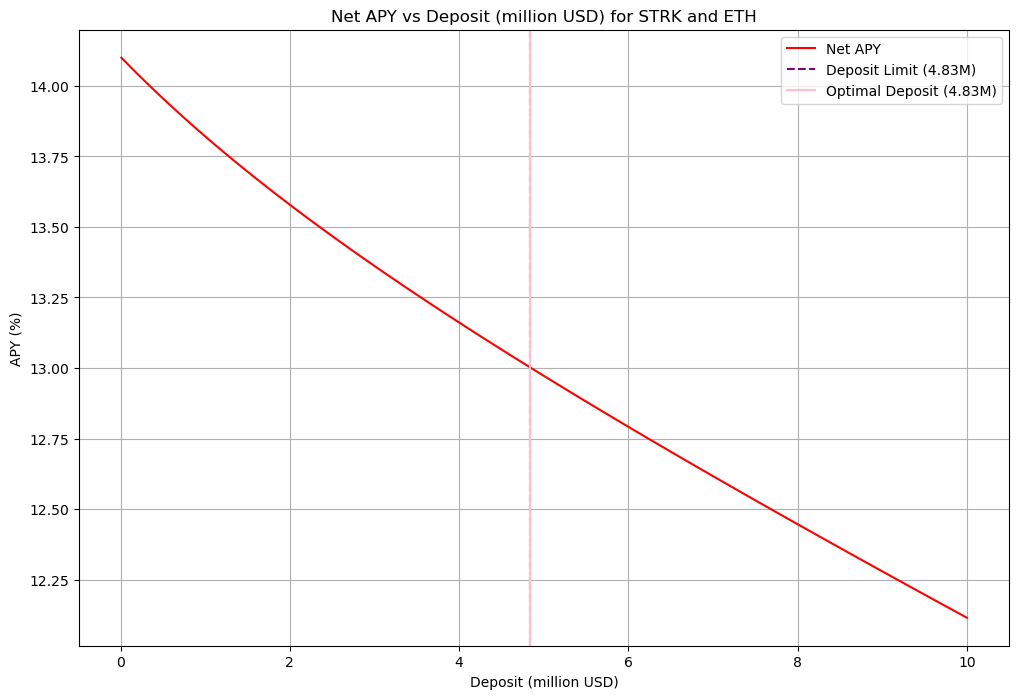

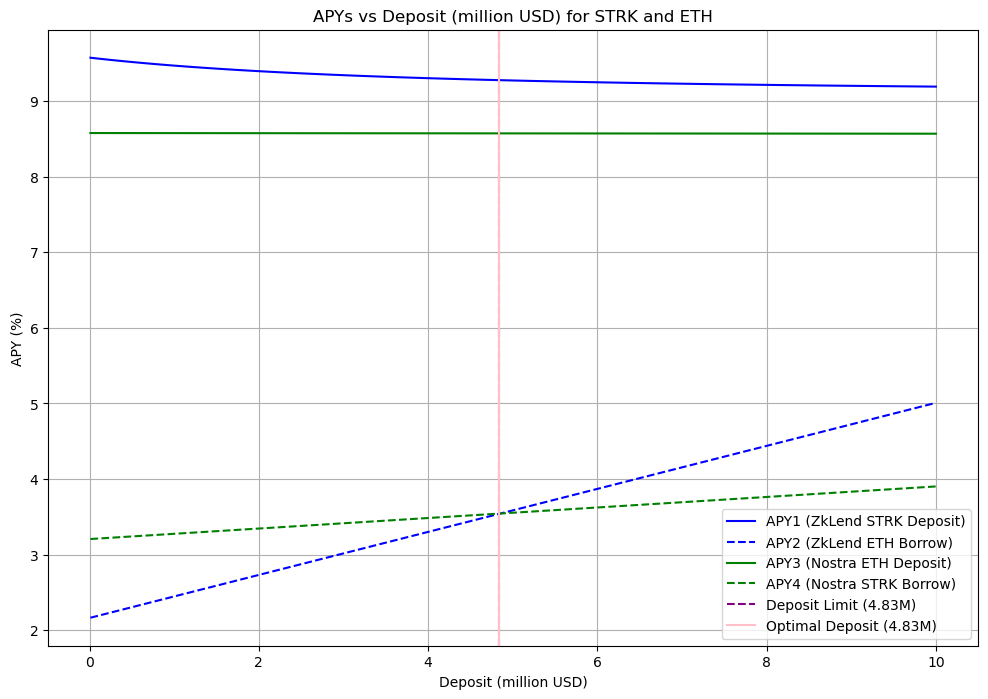

In [68]:
calculate_apy_for_tokens('STRK', 'ETH', protocols, deposits)

# ETH Sensei

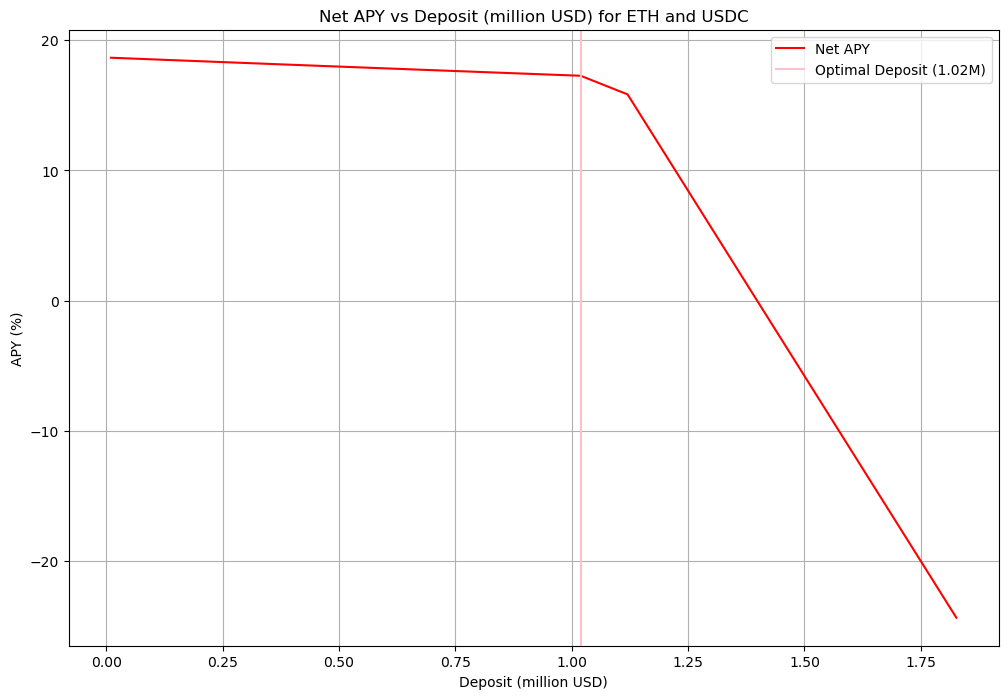

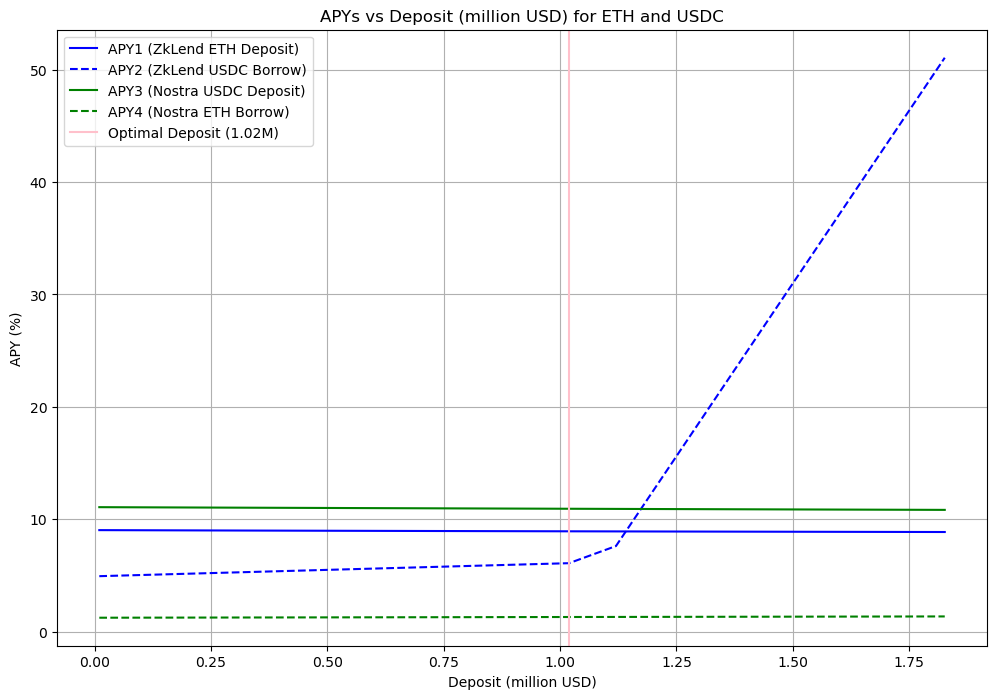

In [69]:
calculate_apy_for_tokens('ETH', 'USDC', protocols, deposits)

# USDC Sensei

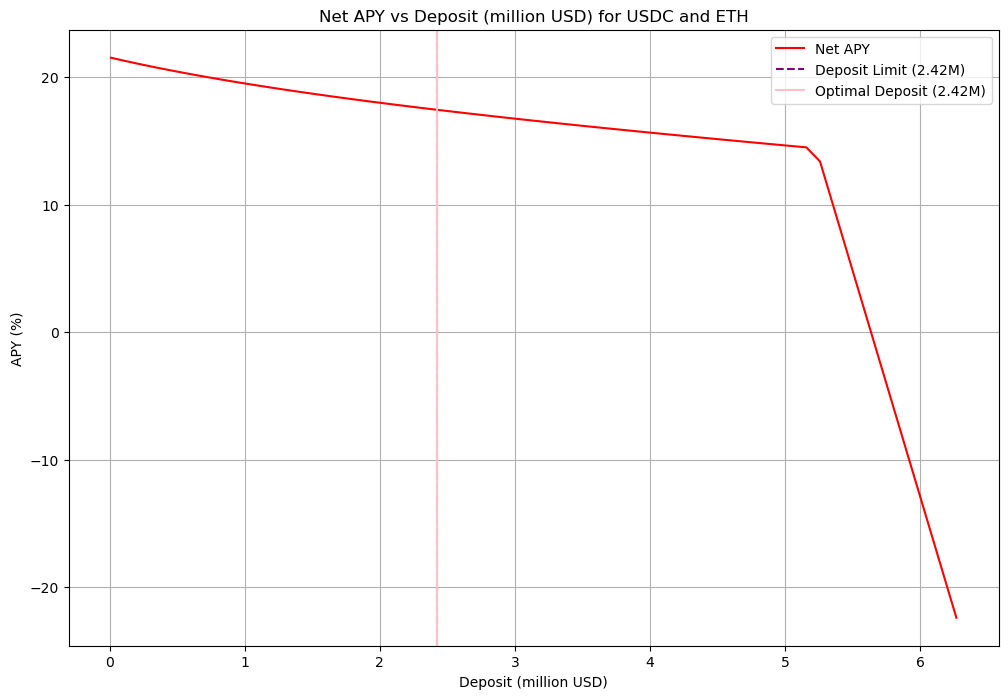

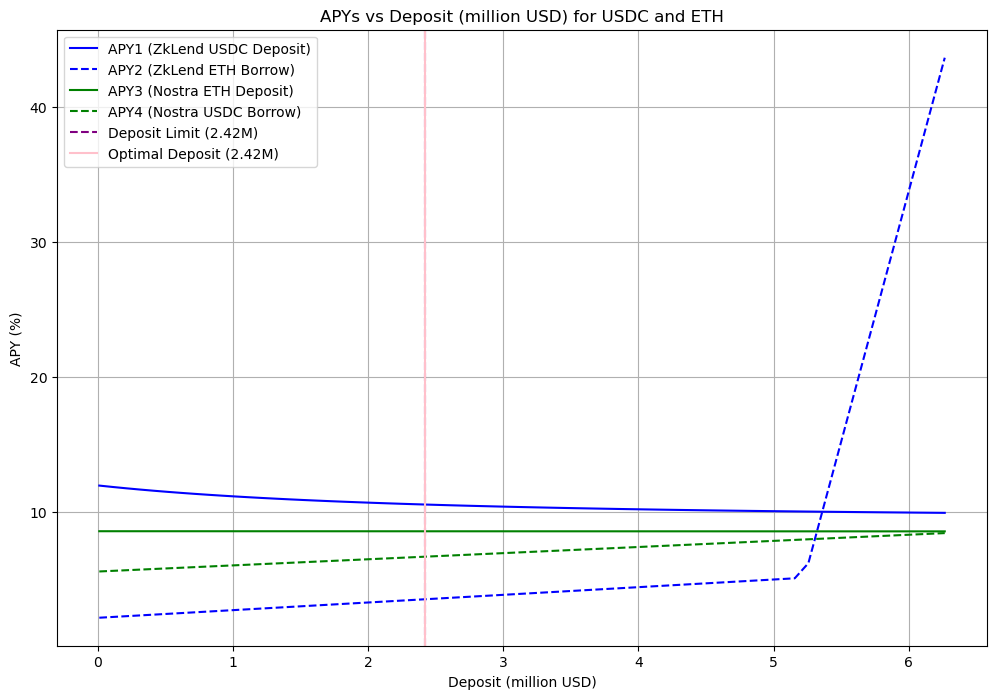

In [70]:
calculate_apy_for_tokens('USDC', 'ETH', protocols, deposits)